## Часть 1

In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import seaborn as sns
import blackjack as bj
sns.set()

In [2]:
env = gym.make("Blackjack-v0", natural=True)

#### Task 1.

Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

In [3]:
class SimplePolicy:
    def run(self, env):
        done = False
        player_score, dealer_score, useable_ace = env.reset()

        while player_score < 19:
            # hit
            (player, dealer, ace), reward, done, _ = env.step(1)
            # if busted
            if done:
                return reward
            else:
                player_score += player
        # if not busted and have 19, 20, 21
        if not done:
            (player, dealer, ace), reward, done, _ = env.step(0)
            return reward

In [36]:
def MonteCarlo_check(policy, env, max_iter = 100000, verbose=True):
    success = 0
    for n in range(100000):
        success = (n * success + policy.run(env)) / (n + 1)
    return success
    if verbose:
        print(f"Monte-Carlo estimation for '{policy.__class__.__name__}' = {success:.4f}")

In [5]:
simple_policy = SimplePolicy()
MonteCarlo_check(simple_policy, env)

Monte-Carlo estimation for 'SimplePolicy' = -0.1076


#### Task 2.

Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [30]:
# monte carlo control
class MCC:
    def __init__(self, alpha = 0.2, gamma = 1):
        self.Q = {state : {0: 0 , 1: 0} for state in product(range(2, 22), range(1, 11), [True, False])}
        self.alpha = alpha
        self.gamma = gamma
    
    def action(self, state, epsilon = 0):
        if np.random.rand() < epsilon:
            return np.random.choice([0, 1])
        else:
            return np.argmax([self.Q[state][0], self.Q[state][1]])

    def episode(self, env, epsilon):
        episode = {'states': [], 'actions': [], 'rewards': []}

        done = False
        state = env.reset()
        
        while True:
            action = self.action(state, epsilon)

            new_state, reward, done, _ = env.step(action)

            episode['states'].append(state)
            episode['actions'].append(action)
            episode['rewards'].append(reward)
            
            if done:
                break
            else:
                state = new_state

        return episode
    
    def update(self, episodes):
        G = [episodes['rewards'][-1]]
        for r in episodes['rewards'][-2::-1]:
            G.append(G[-1]*self.gamma + r)
        G = G[::-1]
        
        for s, a, g in zip(episodes['states'], episodes['actions'], G):
            self.Q[s][a] += self.alpha * (g - self.Q[s][a])
        return self.Q
            
    def run_update(self, env, epsilon):
        episode = self.episode(env, epsilon)
        self.update(episode)
        
    def run(self, env):
        episode = self.episode(env, 0)
        return episode['rewards'][-1]

In [83]:
%%time
epsilon = (1 - np.linspace(1, 0.1, 1000000)**4)[::-1]
policy = MCC(0.02, 1)

avg_gain = []
for i, eps in enumerate(epsilon):
    policy.run_update(env, eps)
    if i % 10000 == 0:
        avg_gain.append(MonteCarlo_check(policy, env, False))

CPU times: user 5min 38s, sys: 4.44 s, total: 5min 43s
Wall time: 5min 35s


Text(0.5, 0, 'Result after 10000 iterations')

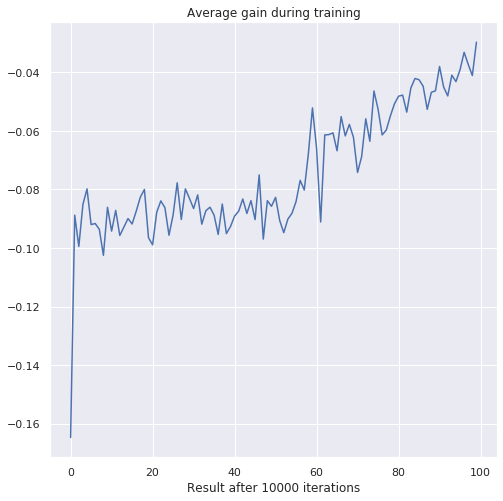

In [86]:
fig = plt.figure(figsize=(8, 8))
plt.title('Average gain during training')
plt.plot(avg_gain)
plt.xlabel("Result after 10000 iterations")

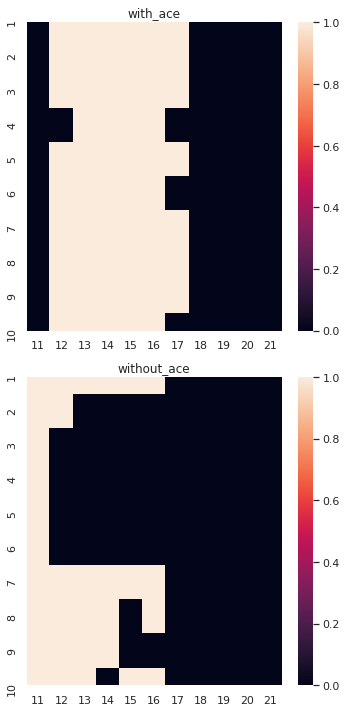

In [91]:
with_ace = np.zeros((10, 11))
without_ace = np.zeros((10, 11))
dealer_id = {i+1: i for i in range(10)}
hands_id = {i+11: i for i in range(11)}

for k, v in policy.Q.items():
    h, d, ace = k
    hit = np.argmax([v[0], v[1]])
    if h < 11:
        continue
    if ace:
        with_ace[dealer_id[d], hands_id[h]] = hit
    else:
        without_ace[dealer_id[d], hands_id[h]] = hit

fig, ax = plt.subplots(2, 1, figsize=(5, 10))

sns.heatmap(with_ace, xticklabels=list(hands_id.keys()), yticklabels=list(dealer_id.keys()), ax=ax[0])
ax[0].set_title('with_ace')

sns.heatmap(without_ace, xticklabels=list(hands_id.keys()), yticklabels=list(dealer_id.keys()), ax=ax[1])
ax[1].set_title('without_ace')

plt.tight_layout()
plt.show()

Почему-то туз не считается использованным ни разу во всех испытаниях.

## Часть 2

In [11]:
env = bj.DoubleBlackjackEnv(natural=True)

In [166]:
# monte carlo control
class MCC_Double(MCC):
    def __init__(self, alpha = 0.2, gamma = 1):
        super().__init__()
        self.Q = {state : {0: 0 , 1: 0, 2: 0} for state in product(range(2, 22), range(1, 11), [True, False])}
        self.alpha = alpha
        self.gamma = gamma
            
    def action(self, state, epsilon = 0):
        if np.random.rand() < epsilon:
            return np.random.choice([0, 1, 2])
        else:
            return np.argmax([self.Q[state][0], self.Q[state][1], self.Q[state][2]])

In [173]:
%%time
epsilon = (1 - np.linspace(1, 0.1, 2000000)**4)[::-1]
policy = MCC_Double(0.02, 1)

avg_gain = []
for i, eps in enumerate(epsilon):
    policy.run_update(env, eps)
    if i % 10000 == 0:
        avg_gain.append(MonteCarlo_check(policy, env, False))

CPU times: user 5min 22s, sys: 2.86 s, total: 5min 25s
Wall time: 5min 20s


Text(0.5, 0, 'Result after 10000 iterations')

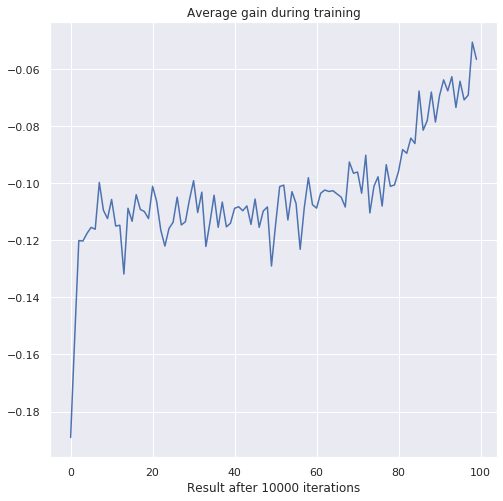

In [174]:
fig = plt.figure(figsize=(8, 8))
plt.title('Average gain during training')
plt.plot(avg_gain)
plt.xlabel("Result after 10000 iterations")

## Часть 3

In [3]:
from importlib import reload

In [41]:
bj = reload(bj)

In [42]:
env = bj.CountDoubleBlackjackEnv(natural=True)

In [43]:
# monte carlo control
class MCC_DoubleCount(MCC):
    def __init__(self, alpha = 0.2, gamma = 1):
        super().__init__()
        self.Q = {state : {0: 0 , 1: 0, 2: 0} for state in 
                  product(range(2, 22), range(1, 11), [True, False], range(-20, 21))}
        self.alpha = alpha
        self.gamma = gamma
            
    def action(self, state, epsilon = 0):
        if np.random.rand() < epsilon:
            return np.random.choice([0, 1, 2])
        else:
            return np.argmax([self.Q[state][0], self.Q[state][1], self.Q[state][2]])

In [46]:
%%time
epsilon = (1 - np.linspace(1, 0.1, 2000000)**4)[::-1]
policy = MCC_DoubleCount(0.02, 1)

avg_gain = []
for i, eps in enumerate(epsilon):
    policy.run_update(env, eps)
    if i % 10000 == 0:
        avg_gain.append(MonteCarlo_check(policy, env, False))

CPU times: user 10min 4s, sys: 7.9 s, total: 10min 12s
Wall time: 9min 59s


Text(0.5, 0, 'Result after 10000 iterations')

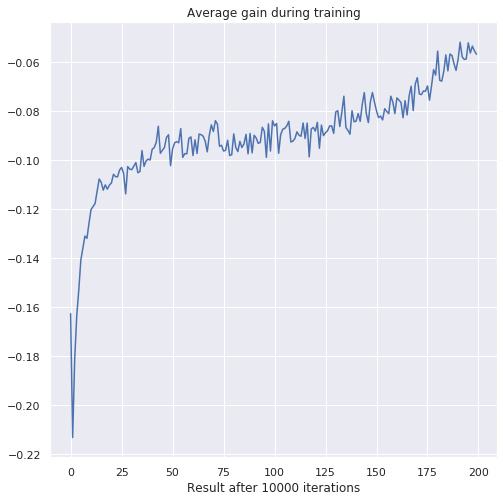

In [47]:
fig = plt.figure(figsize=(8, 8))
plt.title('Average gain during training')
plt.plot(avg_gain)
plt.xlabel("Result after 10000 iterations")